# Qualicum Beach Orthomosaic Processing with GCPs

This notebook processes drone imagery to create orthomosaics using Agisoft Metashape, comparing results with and without ground control points (GCPs).

## Workflow:
1. Load GCPs from KMZ file
2. Download drone imagery from S3 (all 12 cells)
3. Process orthomosaic WITHOUT GCPs
4. Process orthomosaic WITH GCPs
5. Compare both orthomosaics against ESRI and OpenStreetMap basemaps
6. Generate comprehensive quality report


## Setup and Imports


In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Add package to path
package_dir = Path.cwd()
sys.path.insert(0, str(package_dir))

from qualicum_beach_gcp_analysis import (
    load_gcps_from_kmz,
    download_basemap,
    visualize_gcps_on_basemap,
    calculate_gcp_bbox,
    download_all_images_from_input_dir,
    export_to_metashape_csv,
    export_to_metashape_xml,
    process_orthomosaic,
    PhotoMatchQuality,
    DepthMapQuality,
    compare_orthomosaic_to_basemap,
    generate_comparison_report,
    generate_markdown_report,
)

print("✓ Imports successful!")


✓ Imports successful!


## Step 1: Load Ground Control Points


In [2]:
# Path to the KMZ file
kmz_path = "/Users/mauriciohessflores/Documents/Code/Data/Qualicum Beach GCPs/Spexi_Survey_Points/Spexi_Drone_Survey/QualicumBeach_AOI.kmz"

# Load GCPs
gcps = load_gcps_from_kmz(kmz_path)

print(f"\n✓ Loaded {len(gcps)} ground control points")

# Display all GCPs
if gcps:
    print("\nGCPs:")
    for i, gcp in enumerate(gcps):
        print(f"  {i+1:2d}. {gcp.get('id', 'Unknown'):20s}: ({gcp['lat']:.6f}, {gcp['lon']:.6f}, z={gcp.get('z', 0):.2f})")
else:
    print("\n⚠️  No GCPs found!")


Loading GCPs from: /Users/mauriciohessflores/Documents/Code/Data/Qualicum Beach GCPs/Spexi_Survey_Points/Spexi_Drone_Survey/QualicumBeach_AOI.kmz
Found 1 KML file(s) in KMZ
Attempting to fix namespace issues...
✓ Fixed namespace issues in KML file
Found 12 placemarks in KMZ file (namespace: http://www.opengis.net/kml/2.2)
Successfully parsed 12 GCPs from KMZ file

✓ Loaded 12 ground control points

GCPs:
   1. 8928d89ac03ffff     : (49.352544, -124.407904, z=0.00)
   2. 8928d89ac0bffff     : (49.354342, -124.404136, z=0.00)
   3. 8928d89ac1bffff     : (49.351585, -124.403857, z=0.00)
   4. 8928d89ac43ffff     : (49.355182, -124.396319, z=0.00)
   5. 8928d89ac47ffff     : (49.356141, -124.400367, z=0.00)
   6. 8928d89ac53ffff     : (49.352425, -124.396040, z=0.00)
   7. 8928d89ac57ffff     : (49.353384, -124.400088, z=0.00)
   8. 8928d89ac5bffff     : (49.354224, -124.392271, z=0.00)
   9. 8928d89ac73ffff     : (49.357100, -124.404415, z=0.00)
  10. 8928d89acc7ffff     : (49.348828, -12

## Step 2: Calculate Bounding Box and Download Reference Basemaps


In [3]:
# Create output directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Calculate bounding box
bbox = calculate_gcp_bbox(gcps, padding=0.01)
min_lat, min_lon, max_lat, max_lon = bbox

print(f"Bounding box:")
print(f"  Latitude: {min_lat:.6f} to {max_lat:.6f}")
print(f"  Longitude: {min_lon:.6f} to {max_lon:.6f}")

# Download ESRI World Imagery basemap (for comparison)
basemap_esri_path = str(output_dir / "qualicum_beach_basemap_esri.tif")
print("\nDownloading ESRI World Imagery basemap...")
basemap_esri_path = download_basemap(
    bbox=bbox,
    output_path=basemap_esri_path,
    source="esri_world_imagery",
    zoom=None
)
print(f"✓ ESRI basemap saved to: {basemap_esri_path}")

# Download OpenStreetMap basemap (for comparison)
basemap_osm_path = str(output_dir / "qualicum_beach_basemap_osm.tif")
print("\nDownloading OpenStreetMap basemap...")
basemap_osm_path = download_basemap(
    bbox=bbox,
    output_path=basemap_osm_path,
    source="openstreetmap",
    zoom=None
)
print(f"✓ OpenStreetMap basemap saved to: {basemap_osm_path}")


Bounding box:
  Latitude: 49.338828 to 49.367100
  Longitude: -124.417904 to -124.382271

Tile range: X [1264, 1265], Y [2800, 2801]
Basemap saved to outputs/qualicum_beach_basemap_esri.tif
✓ ESRI basemap saved to: outputs/qualicum_beach_basemap_esri.tif

Tile range: X [1264, 1265], Y [2800, 2801]
Basemap saved to outputs/qualicum_beach_basemap_osm.tif
✓ OpenStreetMap basemap saved to: outputs/qualicum_beach_basemap_osm.tif


## Step 3: Download Drone Imagery from S3


In [4]:
# Setup paths
input_dir = Path("input")
photos_dir = Path("input/images")

# Download all images from input manifest files
print("Downloading images from S3...")
print("=" * 60)
download_stats = download_all_images_from_input_dir(
    input_dir=input_dir,
    photos_dir=photos_dir,
    skip_existing=True  # Don't re-download if images already exist
)
print("=" * 60)
print("✓ Image download complete")


2025-11-25 13:36:22,200 - qualicum_beach_gcp_analysis.s3_downloader - INFO - Found 12 manifest files
2025-11-25 13:36:22,358 - qualicum_beach_gcp_analysis.s3_downloader - INFO - Processing manifest: input-file_172543.txt
2025-11-25 13:36:22,359 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Bucket: spexi-data-domain-assets-production-ca-central-1
2025-11-25 13:36:22,359 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   S3 prefix: standardized-images/8928d89ac53ffff/172543/
2025-11-25 13:36:22,359 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Total images: 152
2025-11-25 13:36:22,377 - botocore.tokens - INFO - Loading cached SSO token for spexi


2025-11-25 13:36:27,458 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 10/152 images...
2025-11-25 13:36:31,787 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 20/152 images...
2025-11-25 13:36:35,733 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 30/152 images...
2025-11-25 13:36:40,363 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 40/152 images...
2025-11-25 13:36:44,594 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 50/152 images...
2025-11-25 13:36:48,644 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 60/152 images...
2025-11-25 13:36:53,876 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 70/152 images...
2025-11-25 13:36:58,886 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 80/152 images...
2025-11-25 13:37:03,928 - qualicum_beach_gcp_analysis.s3_downloader - INFO -   Downloaded 90/152 images...
2025-11-25 13:37:09,746 - qualicum_be

✓ Image download complete


## Step 4: Export GCPs for MetaShape


In [ ]:
# Export GCPs to MetaShape XML format (preferred by MetaShape)
gcp_xml_path = output_dir / "gcps_metashape.xml"
export_to_metashape_xml(gcps, str(gcp_xml_path))
print(f"✓ GCPs exported to XML: {gcp_xml_path}")

# Also export CSV for reference
gcp_csv_path = output_dir / "gcps_metashape.csv"
export_to_metashape_csv(gcps, str(gcp_csv_path))
print(f"✓ GCPs also exported to CSV: {gcp_csv_path}")

# Use XML file for processing (MetaShape's native format)
gcp_file_path = gcp_xml_path


Exported 12 GCPs to MetaShape CSV: outputs/gcps_metashape.csv
✓ GCPs exported to: outputs/gcps_metashape.csv


## Step 5: Process Orthomosaic WITHOUT GCPs


In [ ]:
# Setup paths for processing
intermediate_dir = output_dir / "intermediate"
ortho_output_dir = output_dir / "orthomosaics"

# Process orthomosaic WITHOUT GCPs
# Note: clean_intermediate_files=False will reuse existing processing steps
# Set to True to start fresh and delete previous work
print("=" * 60)
print("Processing orthomosaic WITHOUT GCPs...")
print("=" * 60)

project_path_no_gcps = intermediate_dir / "orthomosaic_no_gcps.psx"

stats_no_gcps = process_orthomosaic(
    photos_dir=photos_dir,
    output_path=ortho_output_dir,
    project_path=project_path_no_gcps,
    product_id="orthomosaic_no_gcps",
    clean_intermediate_files=False,  # Reuse existing processing if available
    photo_match_quality=PhotoMatchQuality.MediumQuality,
    depth_map_quality=DepthMapQuality.MediumQuality,
    tiepoint_limit=10000,
    use_gcps=False
)

print("\n✓ Orthomosaic processing (without GCPs) complete!")
print(f"  Number of photos: {stats_no_gcps['num_photos']}")
print(f"\n📁 Output Files:")
ortho_path_no_gcps = Path(stats_no_gcps['ortho_path'])
if ortho_path_no_gcps.exists():
    file_size_mb = ortho_path_no_gcps.stat().st_size / (1024 * 1024)
    print(f"  ✓ Orthomosaic GeoTIFF: {ortho_path_no_gcps.absolute()}")
    print(f"    Size: {file_size_mb:.2f} MB")
else:
    print(f"  ✗ Orthomosaic GeoTIFF NOT FOUND at: {ortho_path_no_gcps.absolute()}")
    print(f"    Expected location: {ortho_path_no_gcps}")
    print(f"    Output directory exists: {ortho_path_no_gcps.parent.exists()}")
if 'log_file_path' in stats_no_gcps:
    print(f"  📝 Log file: {stats_no_gcps['log_file_path']}")


2025-11-25 13:53:18,710 - qualicum_beach_gcp_analysis.metashape_processor - INFO - 🧹 Cleaning up previous processing files...
2025-11-25 13:53:18,712 - qualicum_beach_gcp_analysis.metashape_processor - INFO - 🚀 Initializing Metashape project...


Processing orthomosaic WITHOUT GCPs...
SaveProject: path = outputs/intermediate/orthomosaic_no_gcps.psx
saved project in 0.005374 sec
LoadProject: path = outputs/intermediate/orthomosaic_no_gcps.psx


2025-11-25 13:53:19,123 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Adding photos from: input/images
2025-11-25 13:53:19,132 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Found 1841 images


loaded project in 0.002411 sec
AddPhotos
SaveProject: path = /Users/mauriciohessflores/Documents/Code/MyCode/research-qualicum_beach_gcp_analysis/outputs/intermediate/orthomosaic_no_gcps.psx
saved project in 0.14287 sec


2025-11-25 13:53:20,765 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Matching photos...


MatchPhotos: accuracy = Medium, preselection = generic, reference, keypoint limit = 40000, keypoint limit per mpx = 1000, tiepoint limit = 10000, apply masks = 0, filter tie points = 1, filter stationary points = 1, guided matching = 0
saved matching data in 0.000251 sec
scheduled 93 keypoint detection groups
saved keypoint partition in 0.000172 sec
groups: 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1994
4220 of 1841 used (229.223%)
scheduled 24 keypoint matching groups
saved matching partition in 0.000583 sec
loaded keypoint partition in 4.6e-05 sec
loaded matching data in 1.5e-05 sec
Found 1 GPUs in 0.046789 sec (OpenCL: 0.046778 sec)
Using device: Apple M4 Pro, 16 compute units, 36864 MB global memory, OpenCL 1.2
  driver version: 1.2 1.0, platform version: OpenCL 1.2 (Jul 20 2025 19:29:12)
  max work group size 256
  max work item sizes [256, 256, 256]
  max mem alloc size 6912 MB
Building OpenCL kernels for Ap

## Step 6: Process Orthomosaic WITH GCPs


In [9]:
# Process orthomosaic WITH GCPs
# Note: clean_intermediate_files=False will reuse existing processing steps
# Set to True to start fresh and delete previous work
print("=" * 60)
print("Processing orthomosaic WITH GCPs...")
print("=" * 60)

project_path_with_gcps = intermediate_dir / "orthomosaic_with_gcps.psx"

# Use XML file (MetaShape's native format) - defined in Step 4
gcp_file_for_processing = output_dir / "gcps_metashape.xml"

stats_with_gcps = process_orthomosaic(
    photos_dir=photos_dir,
    output_path=ortho_output_dir,
    project_path=project_path_with_gcps,
    gcp_file=gcp_file_for_processing,  # Use XML file (MetaShape's native format)
    product_id="orthomosaic_with_gcps",
    clean_intermediate_files=False,  # Reuse existing processing if available
    photo_match_quality=PhotoMatchQuality.MediumQuality,
    depth_map_quality=DepthMapQuality.MediumQuality,
    tiepoint_limit=10000,
    use_gcps=True
)

print("\n✓ Orthomosaic processing (with GCPs) complete!")
print(f"  Number of photos: {stats_with_gcps['num_photos']}")
print(f"  Number of markers: {stats_with_gcps.get('num_markers', 0)}")
print(f"\n📁 Output Files:")
ortho_path_with_gcps = Path(stats_with_gcps['ortho_path'])
if ortho_path_with_gcps.exists():
    file_size_mb = ortho_path_with_gcps.stat().st_size / (1024 * 1024)
    print(f"  ✓ Orthomosaic GeoTIFF: {ortho_path_with_gcps.absolute()}")
    print(f"    Size: {file_size_mb:.2f} MB")
else:
    print(f"  ✗ Orthomosaic GeoTIFF NOT FOUND at: {ortho_path_with_gcps.absolute()}")
    print(f"    Expected location: {ortho_path_with_gcps}")
    print(f"    Output directory exists: {ortho_path_with_gcps.parent.exists()}")
if 'log_file_path' in stats_with_gcps:
    print(f"  📝 Log file: {stats_with_gcps['log_file_path']}")


2025-11-25 15:56:20,010 - qualicum_beach_gcp_analysis.metashape_processor - INFO - 🚀 Initializing Metashape project...


Processing orthomosaic WITH GCPs...
SaveProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
saved project in 0.002968 sec
LoadProject: path = outputs/intermediate/orthomosaic_with_gcps.psx
loaded project in 0.000297 sec


2025-11-25 15:56:20,422 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Adding photos from: input/images
2025-11-25 15:56:20,442 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Found 1841 images


AddPhotos
SaveProject: path = /Users/mauriciohessflores/Documents/Code/MyCode/research-qualicum_beach_gcp_analysis/outputs/intermediate/orthomosaic_with_gcps.psx


2025-11-25 15:56:22,083 - qualicum_beach_gcp_analysis.metashape_processor - WARNING - use_gcps=True but no GCPs provided. Processing without GCPs.
2025-11-25 15:56:22,083 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Matching photos...


saved project in 0.115497 sec
MatchPhotos: accuracy = Medium, preselection = generic, reference, keypoint limit = 40000, keypoint limit per mpx = 1000, tiepoint limit = 10000, apply masks = 0, filter tie points = 1, filter stationary points = 1, guided matching = 0
saved matching data in 0.000835 sec
scheduled 93 keypoint detection groups
saved keypoint partition in 0.000596 sec
groups: 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1994
4220 of 1841 used (229.223%)
scheduled 24 keypoint matching groups
saved matching partition in 0.000887 sec
loaded keypoint partition in 2.6e-05 sec
loaded matching data in 1.3e-05 sec
Found 1 GPUs in 2.4e-05 sec (OpenCL: 2.3e-05 sec)
Using device: Apple M4 Pro, 16 compute units, 36864 MB global memory, OpenCL 1.2
  driver version: 1.2 1.0, platform version: OpenCL 1.2 (Jul 20 2025 19:29:12)
  max work group size 256
  max work item sizes [256, 256, 256]
  max mem alloc size 6912 MB
Lo

2025-11-25 16:00:42,731 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Aligning cameras...


saved project in 0.095386 sec
AlignCameras: adaptive fitting = 0
processing matches... done in 0.603095 sec
selecting camera groups... 
groups: 168, 153, 88, 114, 123, 74, 79, 68, 139, 92, 58, 61, 57, 56, 66, 64, 121, 73, 60, 65, 53, 2
n groups: 22, total: 1834, minmax: [2, 168]
done in 0.257515 sec
scheduled 22 alignment groups
saved camera partition in 0.000782 sec
loaded camera partition in 2.1e-05 sec
processing block: 168 photos
pair 99 and 100: 3870 robust from 3878
pair 132 and 133: 3866 robust from 3874
pair 130 and 132: 3754 robust from 3758
pair 98 and 99: 3896 robust from 3901
pair 19 and 121: 4063 robust from 4076
pair 133 and 134: 73 robust from 4461
pair 118 and 119: 4431 robust from 4439
pair 119 and 120: 3795 robust from 3801
pair 166 and 167: 5 robust from 4373
pair 9 and 10: 599 robust from 4682
pair 100 and 101: 3768 robust from 3780
pair 94 and 95: 0 robust from 5155
evaluating initial pair...
initial pair evaluated in 0.365829 sec.
initial pair unstable, considerin

optimal pair not found


iteration 0: 8459 points, 0.0134699 error
iteration 1: 8389 points, 0.0133699 error
iteration 2: 8358 points, 0.0133261 error
iteration 3: 8348 points, 0.0133121 error
iteration 4: 8340 points, 0.0133011 error
groups 0 and 13: 8337 robust from 114941
Aligning groups by 64977 points
iteration 0: 12800 points, 0.0128488 error
iteration 1: 12541 points, 0.0125017 error
iteration 2: 12399 points, 0.0123163 error
iteration 3: 12328 points, 0.0122268 error
iteration 4: 12284 points, 0.0121727 error
groups 0 and 17: 12254 robust from 64977
Aligning groups by 32794 points
iteration 0: 16617 points, 0.0128347 error
iteration 1: 16159 points, 0.0123785 error
iteration 2: 15941 points, 0.012167 error
iteration 3: 15828 points, 0.0120591 error
iteration 4: 15754 points, 0.0119897 error
groups 0 and 5: 15707 robust from 32794
Aligning groups by 26308 points
iteration 0: 15561 points, 0.0120096 error
iteration 1: 15053 points, 0.0112138 error
iteration 2: 14875 points, 0.0109909 error
iteration 3: 1

2025-11-25 16:09:22,279 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Building depth maps...


saved project in 0.375483 sec
BuildDepthMaps: quality = Medium, depth filtering = Mild, PM version
Preparing 1796 cameras info...
cameras data loaded in 0.060576 s
cameras graph built in 2.15318 s
filtering neighbors with too low common points, threshold=50...
Camera 251 has no neighbors
Camera 257 has no neighbors
Camera 1449 has no neighbors
avg neighbors before -> after filtering: 46.0156 -> 17.7751 (61% filtered out)
limiting neighbors to 16 best...
avg neighbors before -> after filtering: 17.7751 -> 14.3146 (19% filtered out)
neighbors number min/1%/10%/median/90%/99%/max: 0, 2, 9, median=16, 16, 16, 16
cameras info prepared in 4.01638 s
saved cameras info in 0.02945
Partitioning 1796 cameras...
number of mini clusters: 37
37 groups: avg_ref=48.5405 avg_neighb=48 total_io=199%
max_ref=49 max_neighb=91 max_total=140
cameras partitioned in 0.016207 s
saved depth map partition in 0.001093 sec
loaded cameras info in 0.032093
loaded depth map partition in 0.000118 sec
already partition

2025-11-25 16:31:10,978 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Building 3D model...


saved project in 0.165677 sec
BuildModel: source data = Depth maps, surface type = Arbitrary, face count = High, volumetric masking = 0, OOC version, interpolation = Enabled, vertex colors = 1
Compression level: 1
Preparing depth maps...
1793 depth maps
scheduled 90 depth map groups (1793 cameras)
saved camera partition in 0.000911 sec
loaded camera partition in 0.000176 sec
saved group #1/90: done in 0.96808 s, 20 cameras, 62.2562 MB data, 24.1406 KB registry
loaded camera partition in 0.000172 sec
saved group #2/90: done in 0.958539 s, 20 cameras, 64.9727 MB data, 24.1406 KB registry
loaded camera partition in 0.000192 sec
saved group #3/90: done in 0.968245 s, 20 cameras, 61.9547 MB data, 24.1406 KB registry
loaded camera partition in 0.000215 sec
saved group #4/90: done in 0.973191 s, 20 cameras, 63.6382 MB data, 24.1406 KB registry
loaded camera partition in 0.000211 sec
saved group #5/90: done in 1.14612 s, 20 cameras, 64.7201 MB data, 24.1406 KB registry
loaded camera partition 

2025-11-25 16:56:00,326 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Building orthomosaic...


saved project in 3.26449 sec
BuildOrthomosaic: surface = Mesh, blending mode = Mosaic, fill holes = 1, ghosting filter = 0, cull faces = 0, refine seamlines = 0, resolution = 0
initializing...
tessellating mesh... done (22681133 -> 22681133 faces)
generating 54523x46474 orthomosaic (10 levels, 0.0292783 resolution)
selected 1796 cameras
saved orthomosaic data in 0.000836 sec
saved camera partition in 0.000748 sec
scheduled 90 orthophoto groups
loaded camera partition in 8e-05 sec
tessellating mesh... done (22681133 -> 22681133 faces)
loaded orthomosaic data in 2.62167 sec
Orthorectifying 20 images
8928d89ac0bffff_172555_0001: 4905x5733 -> 3367x4037
8928d89ac0bffff_172555_0002: 4886x6017 -> 3426x4069
8928d89ac0bffff_172555_0004: 4878x6003 -> 3516x4218
8928d89ac0bffff_172555_0003: 5683x6018 -> 3482x4178
8928d89ac0bffff_172555_0006: 5629x5851 -> 3565x4206
8928d89ac0bffff_172555_0007: 4913x5858 -> 3622x4177
8928d89ac0bffff_172555_0005: 6507x5851 -> 3525x4188
8928d89ac0bffff_172555_0008: 65

2025-11-25 17:10:34,555 - qualicum_beach_gcp_analysis.metashape_processor - INFO - Exporting GeoTIFF to: outputs/orthomosaics/orthomosaic_with_gcps.tif


saved project in 0.15377 sec
ExportRaster: path = outputs/orthomosaics/orthomosaic_with_gcps.tif, description = Orthomosaic generated by Qualicum Beach GCP Analysis (with GCPs)
generating 54523 x 46473 raster in 1 x 1 tiles
SaveProject: path = /Users/mauriciohessflores/Documents/Code/MyCode/research-qualicum_beach_gcp_analysis/outputs/intermediate/orthomosaic_with_gcps.psx
saved project in 0.001731 sec


2025-11-25 17:11:37,470 - qualicum_beach_gcp_analysis.metashape_processor - INFO - ✅ MetaShape processing completed successfully



✓ Orthomosaic processing (with GCPs) complete!
  Number of photos: 1841
  Number of markers: 0

📁 Output Files:
  ✓ Orthomosaic GeoTIFF: /Users/mauriciohessflores/Documents/Code/MyCode/research-qualicum_beach_gcp_analysis/outputs/orthomosaics/orthomosaic_with_gcps.tif
    Size: 12959.35 MB


## Step 7: Compare Orthomosaics to Reference Basemaps

### Comparison Methodology

The orthomosaics are compared to reference basemaps (ESRI World Imagery and OpenStreetMap) using a comprehensive methodology:

#### 1. **Reprojection and Alignment**
   - The orthomosaic is reprojected to match the reference basemap's coordinate reference system (CRS) and spatial extent
   - Bilinear resampling is used to ensure pixel-level alignment
   - Both rasters are normalized to the same spatial resolution

#### 2. **Pixel-level Error Metrics**
   - **RMSE (Root Mean Square Error)**: Measures overall pixel intensity differences between orthomosaic and reference
   - **MAE (Mean Absolute Error)**: Measures average absolute pixel differences
   - **Structural Similarity**: Correlation-based measure indicating how well the orthomosaic structure matches the reference

#### 3. **2D Spatial Error (Feature Matching)**
   - Feature-based matching (SIFT, ORB, or phase correlation) identifies corresponding points between orthomosaic and reference
   - Computes X and Y pixel offsets, providing 2D spatial error measurements
   - This identifies systematic shifts, rotations, or misalignments that pixel-level metrics might miss
   - The method automatically selects the best available algorithm (SIFT > ORB > phase correlation > template matching)

#### 4. **Seamline Detection**
   - Gradient-based analysis detects potential seamline artifacts
   - Identifies high-gradient regions that may indicate stitching errors or discontinuities
   - Reports percentage of pixels flagged as potential seamlines

#### 5. **Comparison Process**
   - Both orthomosaics (with and without GCPs) are compared against the same reference basemap
   - Metrics are computed for each band and averaged for overall statistics
   - Results are saved to JSON files for persistence and later analysis


## Step 7: Compare Orthomosaics to Reference Basemaps


In [1]:
# Compare against ESRI basemap
# Ensure imports and variables are defined
if 'Path' not in locals():
    from pathlib import Path

if 'compare_orthomosaic_to_basemap' not in locals():
    from qualicum_beach_gcp_analysis import compare_orthomosaic_to_basemap

if 'output_dir' not in locals():
    output_dir = Path("outputs")

print("=" * 60)
print("Comparing orthomosaics to ESRI World Imagery basemap...")
print("=" * 60)

comparison_dir = output_dir / "comparisons"

# Ensure basemap paths are defined (from Step 2)
if 'basemap_esri_path' not in locals():
    basemap_esri_path = str(output_dir / "qualicum_beach_basemap_esri.tif")

# Determine orthomosaic paths - use stats if available, otherwise find files directly
if 'stats_no_gcps' in locals() and 'ortho_path' in stats_no_gcps:
    ortho_no_gcps_path = Path(stats_no_gcps['ortho_path'])
else:
    # Try to find the orthomosaic file directly
    ortho_output_dir = output_dir / "orthomosaics"
    ortho_no_gcps_path = ortho_output_dir / "orthomosaic_no_gcps.tif"
    if not ortho_no_gcps_path.exists():
        raise FileNotFoundError(f"Orthomosaic (no GCPs) not found at: {ortho_no_gcps_path.absolute()}\n"
                               f"Please run Step 5 first, or ensure the file exists at this location.")

if 'stats_with_gcps' in locals() and 'ortho_path' in stats_with_gcps:
    ortho_with_gcps_path = Path(stats_with_gcps['ortho_path'])
else:
    # Try to find the orthomosaic file directly
    ortho_output_dir = output_dir / "orthomosaics"
    ortho_with_gcps_path = ortho_output_dir / "orthomosaic_with_gcps.tif"
    if not ortho_with_gcps_path.exists():
        raise FileNotFoundError(f"Orthomosaic (with GCPs) not found at: {ortho_with_gcps_path.absolute()}\n"
                               f"Please run Step 6 first, or ensure the file exists at this location.")

print(f"Using orthomosaic (no GCPs): {ortho_no_gcps_path}")
print(f"Using orthomosaic (with GCPs): {ortho_with_gcps_path}")

# Compare without GCPs
print("\nComparing orthomosaic (without GCPs) to ESRI basemap...")
metrics_no_gcps_esri = compare_orthomosaic_to_basemap(
    ortho_path=ortho_no_gcps_path,
    basemap_path=Path(basemap_esri_path),
    output_dir=comparison_dir
)

# Compare with GCPs
print("\nComparing orthomosaic (with GCPs) to ESRI basemap...")
metrics_with_gcps_esri = compare_orthomosaic_to_basemap(
    ortho_path=ortho_with_gcps_path,
    basemap_path=Path(basemap_esri_path),
    output_dir=comparison_dir
)

print("\n✓ ESRI comparison complete!")

# Save metrics to JSON files for later use
import json
from qualicum_beach_gcp_analysis.report_generator import convert_to_json_serializable

metrics_dir = comparison_dir / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

# Save ESRI metrics
metrics_no_gcps_esri_serializable = convert_to_json_serializable(metrics_no_gcps_esri)
metrics_with_gcps_esri_serializable = convert_to_json_serializable(metrics_with_gcps_esri)

with open(metrics_dir / "metrics_no_gcps_esri.json", 'w') as f:
    json.dump(metrics_no_gcps_esri_serializable, f, indent=2)
with open(metrics_dir / "metrics_with_gcps_esri.json", 'w') as f:
    json.dump(metrics_with_gcps_esri_serializable, f, indent=2)

print(f"✓ Metrics saved to: {metrics_dir}")


Comparing orthomosaics to ESRI World Imagery basemap...
Using orthomosaic (no GCPs): outputs/orthomosaics/orthomosaic_no_gcps.tif
Using orthomosaic (with GCPs): outputs/orthomosaics/orthomosaic_with_gcps.tif

Comparing orthomosaic (without GCPs) to ESRI basemap...

Comparing orthomosaic (with GCPs) to ESRI basemap...

✓ ESRI comparison complete!
✓ Metrics saved to: outputs/comparisons/metrics


In [2]:
# Compare against OpenStreetMap basemap
# Ensure imports and variables are defined
if 'Path' not in locals():
    from pathlib import Path

if 'compare_orthomosaic_to_basemap' not in locals():
    from qualicum_beach_gcp_analysis import compare_orthomosaic_to_basemap

if 'output_dir' not in locals():
    output_dir = Path("outputs")
if 'comparison_dir' not in locals():
    comparison_dir = output_dir / "comparisons"
if 'basemap_osm_path' not in locals():
    basemap_osm_path = str(output_dir / "qualicum_beach_basemap_osm.tif")

print("=" * 60)
print("Comparing orthomosaics to OpenStreetMap basemap...")
print("=" * 60)

# Determine orthomosaic paths - use stats if available, otherwise find files directly
if 'ortho_no_gcps_path' not in locals():
    if 'stats_no_gcps' in locals() and 'ortho_path' in stats_no_gcps:
        ortho_no_gcps_path = Path(stats_no_gcps['ortho_path'])
    else:
        ortho_output_dir = output_dir / "orthomosaics"
        ortho_no_gcps_path = ortho_output_dir / "orthomosaic_no_gcps.tif"
        if not ortho_no_gcps_path.exists():
            raise FileNotFoundError(f"Orthomosaic (no GCPs) not found at: {ortho_no_gcps_path.absolute()}")

if 'ortho_with_gcps_path' not in locals():
    if 'stats_with_gcps' in locals() and 'ortho_path' in stats_with_gcps:
        ortho_with_gcps_path = Path(stats_with_gcps['ortho_path'])
    else:
        ortho_output_dir = output_dir / "orthomosaics"
        ortho_with_gcps_path = ortho_output_dir / "orthomosaic_with_gcps.tif"
        if not ortho_with_gcps_path.exists():
            raise FileNotFoundError(f"Orthomosaic (with GCPs) not found at: {ortho_with_gcps_path.absolute()}")

# Compare without GCPs
print("\nComparing orthomosaic (without GCPs) to OpenStreetMap basemap...")
metrics_no_gcps_osm = compare_orthomosaic_to_basemap(
    ortho_path=ortho_no_gcps_path,
    basemap_path=Path(basemap_osm_path),
    output_dir=comparison_dir
)

# Compare with GCPs
print("\nComparing orthomosaic (with GCPs) to OpenStreetMap basemap...")
metrics_with_gcps_osm = compare_orthomosaic_to_basemap(
    ortho_path=ortho_with_gcps_path,
    basemap_path=Path(basemap_osm_path),
    output_dir=comparison_dir
)

print("\n✓ OpenStreetMap comparison complete!")

# Save metrics to JSON files for later use
if 'json' not in locals():
    import json
if 'convert_to_json_serializable' not in locals():
    from qualicum_beach_gcp_analysis.report_generator import convert_to_json_serializable

if 'metrics_dir' not in locals():
    metrics_dir = comparison_dir / "metrics"
    metrics_dir.mkdir(parents=True, exist_ok=True)

# Save OpenStreetMap metrics
metrics_no_gcps_osm_serializable = convert_to_json_serializable(metrics_no_gcps_osm)
metrics_with_gcps_osm_serializable = convert_to_json_serializable(metrics_with_gcps_osm)

with open(metrics_dir / "metrics_no_gcps_osm.json", 'w') as f:
    json.dump(metrics_no_gcps_osm_serializable, f, indent=2)
with open(metrics_dir / "metrics_with_gcps_osm.json", 'w') as f:
    json.dump(metrics_with_gcps_osm_serializable, f, indent=2)

print(f"✓ Metrics saved to: {metrics_dir}")


Comparing orthomosaics to OpenStreetMap basemap...

Comparing orthomosaic (without GCPs) to OpenStreetMap basemap...

Comparing orthomosaic (with GCPs) to OpenStreetMap basemap...

✓ OpenStreetMap comparison complete!
✓ Metrics saved to: outputs/comparisons/metrics


## Step 8: Generate Quality Reports


Loading saved metrics from: outputs/comparisons/metrics
✓ Loaded saved ESRI comparison metrics
Generating quality reports...

✓ ESRI report saved:
  JSON: outputs/quality_report_esri.json
  Markdown: outputs/quality_report_esri.md

Generating visualizations...
  Loading orthomosaics and reference basemap...
  Creating comparison visualizations...


ValueError: operands could not be broadcast together with shapes (46454,54465) (253,207) 

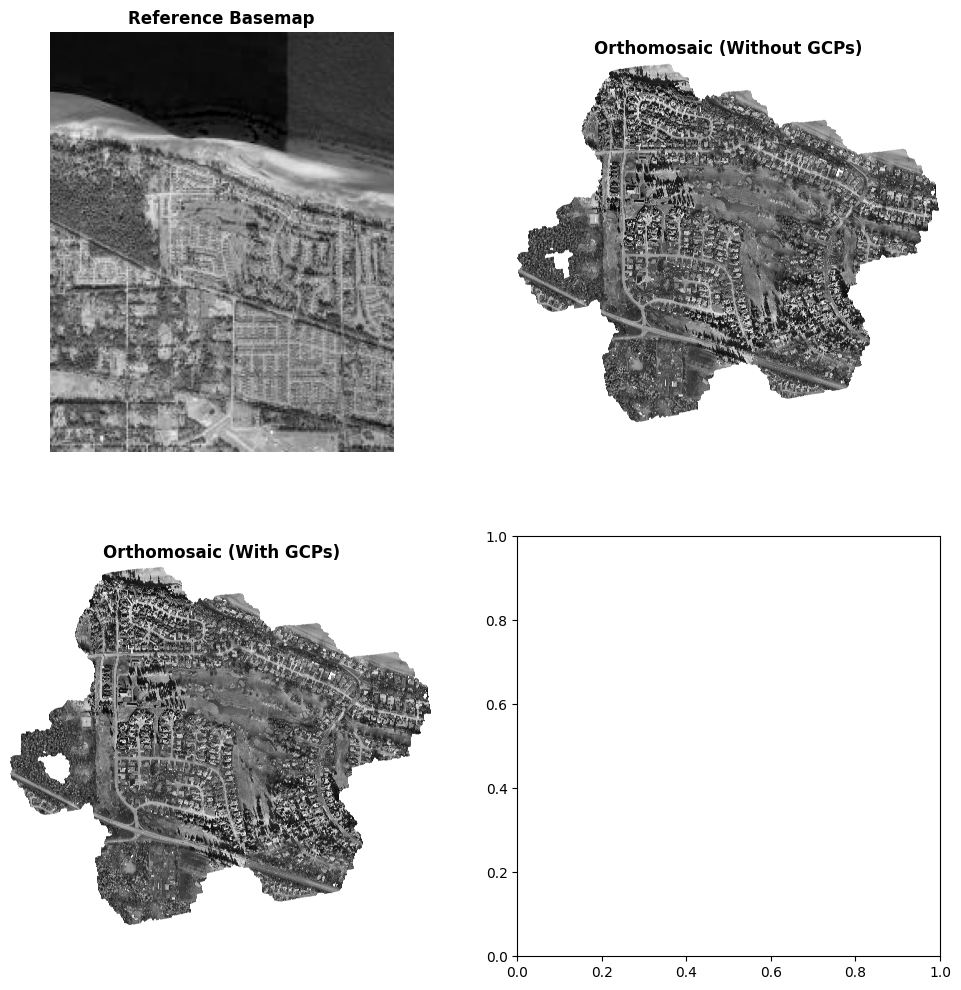

In [1]:
# Generate report for ESRI comparison
# Ensure imports and variables are defined
if 'Path' not in locals():
    from pathlib import Path

if 'generate_comparison_report' not in locals():
    from qualicum_beach_gcp_analysis import (
        generate_comparison_report, 
        generate_markdown_report,
        generate_latex_report,
        create_error_visualization,
        create_seamline_visualization,
        create_comparison_side_by_side,
        create_metrics_summary_plot
    )
    
if 'numpy' not in locals():
    import numpy as np
if 'rasterio' not in locals():
    import rasterio
if 'json' not in locals():
    import json

if 'output_dir' not in locals():
    output_dir = Path("outputs")
if 'comparison_dir' not in locals():
    comparison_dir = output_dir / "comparisons"

# Load metrics from Step 7 if available, otherwise check for saved files
if 'metrics_no_gcps_esri' not in locals() or 'metrics_with_gcps_esri' not in locals():
    # Try to load from saved JSON files
    metrics_dir = comparison_dir / "metrics"
    metrics_file_no_gcps = metrics_dir / "metrics_no_gcps_esri.json"
    metrics_file_with_gcps = metrics_dir / "metrics_with_gcps_esri.json"
    
    if metrics_file_no_gcps.exists() and metrics_file_with_gcps.exists():
        print(f"Loading saved metrics from: {metrics_dir}")
        with open(metrics_file_no_gcps, 'r') as f:
            metrics_no_gcps_esri = json.load(f)
        with open(metrics_file_with_gcps, 'r') as f:
            metrics_with_gcps_esri = json.load(f)
        print("✓ Loaded saved ESRI comparison metrics")
    else:
        raise NameError(
            f"metrics_no_gcps_esri and metrics_with_gcps_esri must be defined. "
            f"Please run Step 7 first, or ensure saved metrics exist at:\n"
            f"  {metrics_file_no_gcps}\n"
            f"  {metrics_file_with_gcps}"
        )

print("=" * 60)
print("Generating quality reports...")
print("=" * 60)

# ESRI report
report_json_esri = output_dir / "quality_report_esri.json"
report_md_esri = output_dir / "quality_report_esri.md"

generate_comparison_report(
    metrics_with_gcps=metrics_with_gcps_esri,
    metrics_without_gcps=metrics_no_gcps_esri,
    output_path=report_json_esri,
    basemap_source="ESRI World Imagery"
)

generate_markdown_report(
    json_report_path=report_json_esri,
    output_path=report_md_esri
)

print(f"\n✓ ESRI report saved:")
print(f"  JSON: {report_json_esri}")
print(f"  Markdown: {report_md_esri}")

# Ensure orthomosaic paths are defined
if 'ortho_no_gcps_path' not in locals():
    ortho_output_dir = output_dir / "orthomosaics"
    ortho_no_gcps_path = ortho_output_dir / "orthomosaic_no_gcps.tif"
    if not ortho_no_gcps_path.exists():
        raise FileNotFoundError(f"Orthomosaic (no GCPs) not found at: {ortho_no_gcps_path.absolute()}")
if 'ortho_with_gcps_path' not in locals():
    ortho_output_dir = output_dir / "orthomosaics"
    ortho_with_gcps_path = ortho_output_dir / "orthomosaic_with_gcps.tif"
    if not ortho_with_gcps_path.exists():
        raise FileNotFoundError(f"Orthomosaic (with GCPs) not found at: {ortho_with_gcps_path.absolute()}")
if 'basemap_esri_path' not in locals():
    basemap_esri_path = str(output_dir / "qualicum_beach_basemap_esri.tif")

# Generate visualizations for ESRI comparison
print("\nGenerating visualizations...")
vis_dir = output_dir / "visualizations" / "esri"
vis_dir.mkdir(parents=True, exist_ok=True)

# Load orthomosaics and reference for visualization
print("  Loading orthomosaics and reference basemap...")
with rasterio.open(ortho_no_gcps_path) as src:
    ortho_no_gcps = src.read(1)  # First band
with rasterio.open(ortho_with_gcps_path) as src:
    ortho_with_gcps = src.read(1)  # First band
with rasterio.open(basemap_esri_path) as src:
    reference_esri = src.read(1)  # First band

# Create visualizations
print("  Creating comparison visualizations...")
create_comparison_side_by_side(
    ortho_no_gcps, ortho_with_gcps, reference_esri,
    vis_dir / "comparison_side_by_side.png",
    title="ESRI Basemap Comparison"
)

create_metrics_summary_plot(
    metrics_no_gcps_esri, metrics_with_gcps_esri,
    vis_dir / "metrics_summary.png",
    title="ESRI Basemap Quality Metrics"
)

create_seamline_visualization(
    ortho_no_gcps,
    vis_dir / "seamlines_no_gcps.png",
    title="Seamlines - Without GCPs"
)

create_seamline_visualization(
    ortho_with_gcps,
    vis_dir / "seamlines_with_gcps.png",
    title="Seamlines - With GCPs"
)

create_error_visualization(
    ortho_no_gcps, reference_esri,
    vis_dir / "error_no_gcps.png",
    title="Error Map - Without GCPs"
)

create_error_visualization(
    ortho_with_gcps, reference_esri,
    vis_dir / "error_with_gcps.png",
    title="Error Map - With GCPs"
)

print(f"✓ Visualizations saved to: {vis_dir}")

# Generate LaTeX/PDF report
print("\nGenerating LaTeX/PDF report...")
report_latex_esri = output_dir / "quality_report_esri"
latex_result = generate_latex_report(
    json_report_path=report_json_esri,
    output_path=report_latex_esri,
    visualization_dir=vis_dir
)

if latex_result.suffix == '.pdf':
    print(f"✓ PDF report generated: {latex_result}")
else:
    print(f"✓ LaTeX file generated: {latex_result}")
    print("  (Install LaTeX and run: pdflatex quality_report_esri.tex to generate PDF)")

# OpenStreetMap report
# Load metrics from Step 7 if available, otherwise check for saved files
if 'metrics_no_gcps_osm' not in locals() or 'metrics_with_gcps_osm' not in locals():
    # Try to load from saved JSON files
    if 'metrics_dir' not in locals():
        metrics_dir = comparison_dir / "metrics"
    metrics_file_no_gcps = metrics_dir / "metrics_no_gcps_osm.json"
    metrics_file_with_gcps = metrics_dir / "metrics_with_gcps_osm.json"
    
    if metrics_file_no_gcps.exists() and metrics_file_with_gcps.exists():
        print(f"Loading saved metrics from: {metrics_dir}")
        if 'json' not in locals():
            import json
        with open(metrics_file_no_gcps, 'r') as f:
            metrics_no_gcps_osm = json.load(f)
        with open(metrics_file_with_gcps, 'r') as f:
            metrics_with_gcps_osm = json.load(f)
        print("✓ Loaded saved OpenStreetMap comparison metrics")
    else:
        raise NameError(
            f"metrics_no_gcps_osm and metrics_with_gcps_osm must be defined. "
            f"Please run Step 7 first, or ensure saved metrics exist at:\n"
            f"  {metrics_file_no_gcps}\n"
            f"  {metrics_file_with_gcps}"
        )

report_json_osm = output_dir / "quality_report_osm.json"
report_md_osm = output_dir / "quality_report_osm.md"

generate_comparison_report(
    metrics_with_gcps=metrics_with_gcps_osm,
    metrics_without_gcps=metrics_no_gcps_osm,
    output_path=report_json_osm,
    basemap_source="OpenStreetMap"
)

generate_markdown_report(
    json_report_path=report_json_osm,
    output_path=report_md_osm
)

print(f"\n✓ OpenStreetMap report saved:")
print(f"  JSON: {report_json_osm}")
print(f"  Markdown: {report_md_osm}")

# Generate visualizations for OpenStreetMap comparison
print("\nGenerating visualizations for OpenStreetMap...")
vis_dir_osm = output_dir / "visualizations" / "osm"
vis_dir_osm.mkdir(parents=True, exist_ok=True)

# Ensure basemap path is defined
if 'basemap_osm_path' not in locals():
    basemap_osm_path = str(output_dir / "qualicum_beach_basemap_osm.tif")

# Load reference basemap for visualization
print("  Loading reference basemap...")
with rasterio.open(basemap_osm_path) as src:
    reference_osm = src.read(1)  # First band

# Reuse orthomosaics already loaded (or load if not available)
if 'ortho_no_gcps' not in locals():
    with rasterio.open(ortho_no_gcps_path) as src:
        ortho_no_gcps = src.read(1)
if 'ortho_with_gcps' not in locals():
    with rasterio.open(ortho_with_gcps_path) as src:
        ortho_with_gcps = src.read(1)

# Create visualizations
print("  Creating comparison visualizations...")
create_comparison_side_by_side(
    ortho_no_gcps, ortho_with_gcps, reference_osm,
    vis_dir_osm / "comparison_side_by_side.png",
    title="OpenStreetMap Basemap Comparison"
)

create_metrics_summary_plot(
    metrics_no_gcps_osm, metrics_with_gcps_osm,
    vis_dir_osm / "metrics_summary.png",
    title="OpenStreetMap Basemap Quality Metrics"
)

create_seamline_visualization(
    ortho_no_gcps,
    vis_dir_osm / "seamlines_no_gcps.png",
    title="Seamlines - Without GCPs"
)

create_seamline_visualization(
    ortho_with_gcps,
    vis_dir_osm / "seamlines_with_gcps.png",
    title="Seamlines - With GCPs"
)

create_error_visualization(
    ortho_no_gcps, reference_osm,
    vis_dir_osm / "error_no_gcps.png",
    title="Error Map - Without GCPs"
)

create_error_visualization(
    ortho_with_gcps, reference_osm,
    vis_dir_osm / "error_with_gcps.png",
    title="Error Map - With GCPs"
)

print(f"✓ Visualizations saved to: {vis_dir_osm}")

# Generate LaTeX/PDF report
print("\nGenerating LaTeX/PDF report for OpenStreetMap...")
report_latex_osm = output_dir / "quality_report_osm"
latex_result_osm = generate_latex_report(
    json_report_path=report_json_osm,
    output_path=report_latex_osm,
    visualization_dir=vis_dir_osm
)

if latex_result_osm.suffix == '.pdf':
    print(f"✓ PDF report generated: {latex_result_osm}")
else:
    print(f"✓ LaTeX file generated: {latex_result_osm}")
    print("  (Install LaTeX and run: pdflatex quality_report_osm.tex to generate PDF)")


## Step 9: Display Report Summary


In [ ]:
# Display summary from ESRI report
import json

print("=" * 60)
print("QUALITY COMPARISON SUMMARY (ESRI World Imagery)")
print("=" * 60)

with open(report_json_esri, 'r') as f:
    report_esri = json.load(f)

comparison = report_esri.get('comparison', {})

if comparison.get('rmse_improvement'):
    rmse = comparison['rmse_improvement']
    print(f"\nRMSE Improvement: {rmse['percentage']:+.2f}%")
    print(f"  Without GCPs: {rmse['without_gcps']:.4f}")
    print(f"  With GCPs:    {rmse['with_gcps']:.4f}")

if comparison.get('mae_improvement'):
    mae = comparison['mae_improvement']
    print(f"\nMAE Improvement: {mae['percentage']:+.2f}%")
    print(f"  Without GCPs: {mae['without_gcps']:.4f}")
    print(f"  With GCPs:    {mae['with_gcps']:.4f}")

if comparison.get('similarity_improvement'):
    sim = comparison['similarity_improvement']
    print(f"\nSimilarity Improvement: {sim['percentage']:+.2f}%")
    print(f"  Without GCPs: {sim['without_gcps']:.4f}")
    print(f"  With GCPs:    {sim['with_gcps']:.4f}")

if comparison.get('seamline_reduction'):
    seam = comparison['seamline_reduction']
    print(f"\nSeamline Reduction: {seam['percentage']:+.2f}%")
    print(f"  Without GCPs: {seam['without_gcps']:.2f}%")
    print(f"  With GCPs:    {seam['with_gcps']:.2f}%")

print("\n" + "=" * 60)
print(f"Full reports available at:")
print(f"  {report_md_esri}")
print(f"  {report_md_osm}")
print("=" * 60)
